# Example 1: Loading Data
First we import the necessary modules

In [8]:
import torch
from pythermondt.readers import LocalReader
from pythermondt.io import HDF5Parser
from pythermondt.data import Units

Next we create a reader object, for accessing DataContainers. In pyThermoNDT a reader does 2 things:
1. It reads the data from the specified source ==> This is done by the **reader classes**
2. It parses the data into a DataContainer object ==> This is done by the **parser classes**

Normally you do not have the worry about this distinction, because the reader classes automatically try to select the correct parser based on the file extension. If no parser is found, the reader will raise an error Optionally you can also specify the parser class explicitly.

In this example we want to read HDF5 files from example folder on the local disk. Therefore we use a **LocalReader** and specify the source expression + file extension. 

**Note1:** The source expression is a string that specifies the path to one or more files. The source expression can be a file path, a folder path or a regular expression. Other readers might have different source expressions (e.g. S3Readers also need a bucket name, etc.).

In [9]:
# Both of these readers are equivalent
reader1 = LocalReader(
    source="./example_data",
    parser=HDF5Parser,
)

reader2 = LocalReader(
    source="./example_data/*.hdf5"
)

print(reader1.file_names)
print(reader2.file_names)

['example-data0.hdf5', 'example-data1.hdf5', 'example-data2.hdf5']
['example-data0.hdf5', 'example-data1.hdf5', 'example-data2.hdf5']


The reader class provides properties about the files found by the specified source expression and some other useful information.

In [10]:
# Files found by the reader
print(reader1.files)
print(reader1.file_names)

# Other information
print(reader1.num_files)
print(reader1.file_extensions)
print(reader1.parser)

['./example_data\\example-data0.hdf5', './example_data\\example-data1.hdf5', './example_data\\example-data2.hdf5']
['example-data0.hdf5', 'example-data1.hdf5', 'example-data2.hdf5']
3
('.h5', '.hdf5')
<class 'pythermondt.io.parsers.hdf5_parser.HDF5Parser'>


The Reader object is indexable and iterable
This means, that on each call, the reader only loads one file at a time from the file system and parses it into a DataContainer object, which is then returned
This is very memory efficient, as it allows for lazy loading of data, and only loads data when it is needed

In [11]:
for i, container in enumerate(reader2, 1):
    if i > 2:
        break
    print(f"container: {i} \n" + container.__str__())

container: 1 
/: (root: NodeType.ROOT)
/Data: (Data: NodeType.GROUP)
/Data/Tdata: (Tdata: NodeType.DATASET)
/GroundTruth: (GroundTruth: NodeType.GROUP)
/GroundTruth/DefectMask: (DefectMask: NodeType.DATASET)
/MetaData: (MetaData: NodeType.GROUP)
/MetaData/DomainValues: (DomainValues: NodeType.DATASET)
/MetaData/ExcitationSignal: (ExcitationSignal: NodeType.DATASET)
/MetaData/LookUpTable: (LookUpTable: NodeType.DATASET)

container: 2 
/: (root: NodeType.ROOT)
/Data: (Data: NodeType.GROUP)
/Data/Tdata: (Tdata: NodeType.DATASET)
/GroundTruth: (GroundTruth: NodeType.GROUP)
/GroundTruth/DefectMask: (DefectMask: NodeType.DATASET)
/MetaData: (MetaData: NodeType.GROUP)
/MetaData/DomainValues: (DomainValues: NodeType.DATASET)
/MetaData/ExcitationSignal: (ExcitationSignal: NodeType.DATASET)
/MetaData/LookUpTable: (LookUpTable: NodeType.DATASET)



The DataContainer object is hierarchically structured (similar to a HDF5 file) and consists of groups and datasets.
Each group can contain multiple groups and datasets. Both groups and datasets can have attributes. Internally datasets are stored as pytorch tensors and attributes as dictionaries. The Datacontainer class includes various methods to access and manipulate the data:

In [12]:
container = reader1[0]
print(container.get_dataset("/MetaData/LookUpTable"))

container.update_dataset("/MetaData/LookUpTable", data=torch.Tensor([1, 2, 3, 4, 5]))

print(container.get_dataset("/MetaData/LookUpTable"))

tensor([293.1500, 293.1502, 293.1505,  ..., 309.3511, 309.3514, 309.3516],
       dtype=torch.float64)
tensor([1., 2., 3., 4., 5.])


Each dataset in the datacontainer also has a unit attribute, which is a dict that describes the physical unit of the data. All the available units are defined in the Units class in the datamodule: 

In [13]:
# Available units
Units.print_available_units()

Available units:
name: quantity (symbol)

dimensionless: dimensionless (1)
arbitrary: arbitrary (a. u.)
undefined: undefined (N/A)
kelvin: temperature (K)
celsius: temperature (°C)
second: time (s)
millisecond: time (ms)


The unit dict can be accessed via the get_unit method of the datacontainer.

In [14]:
# Accessing units
print("\n Accessing units:")
print(container.get_unit("/MetaData/LookUpTable"))
print(container.get_unit("/Data/Tdata"))


 Accessing units:
{'name': 'kelvin', 'quantity': 'temperature', 'symbol': 'K'}
{'name': 'arbitrary', 'quantity': 'arbitrary', 'symbol': 'a. u.'}


The DataContainer object also provides methods to view frames or the pixel profile of the Temperature data. These functions automatically generate the correct labels based on the unit of the data. In case of the pixel profile, the Temperature data is labeled as arbitrary, because the data itself inside the datacontainer is stored in UINT16 format. To get the correct temperature values, the data has to be converted using the LookUpTable in the datacontainer. See [example 3](./example3_transforming_data.ipynb) for more information on how to do this.

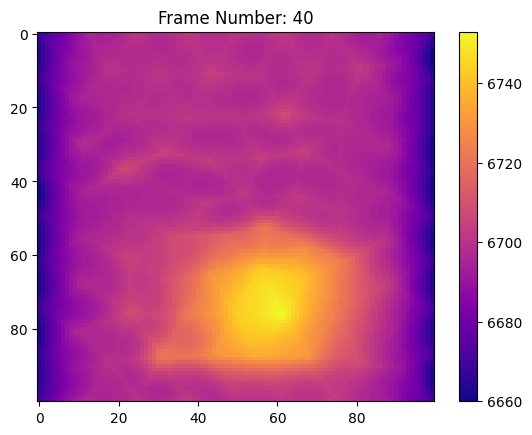

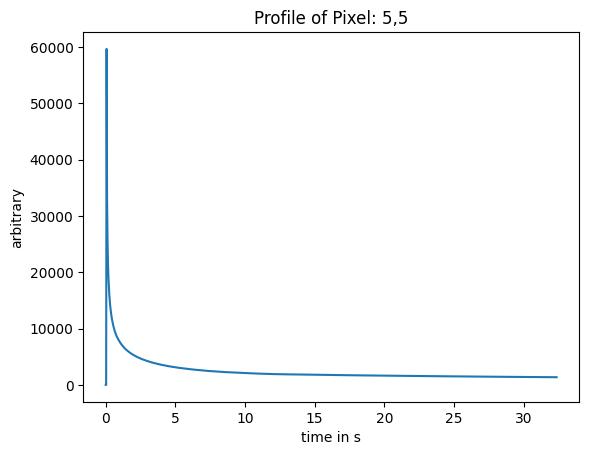

In [15]:
container = reader2[2]

container.show_frame(40)
container.show_pixel_profile(5, 5)  